# Predicting Loan Defaults

### Names:
Hayden Strikwerda, Bryce Kastner, and Hannah George

### Project Summary

Our project is to predict loan defaults using machine learning. Through this project we hope to gain a clearer understanding of what factors most strongly influence whether a loan is approved or not, and then use those factors in different machine learning algorithms.

In order to do so we first found our dataset (located at http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff) and cleaned it, turning each of the columns into numerical data. We saved the cleaned data into a .csv file for ease of use.

After reloading the .csv file, we created bar graphs to visualize the relationship between each of the discrete variables and the class of the loan (approved or denied). Since the ordering of the catagories is largely irrelevant in most cases, we decided to go through each of them and decide which order best benefits our machine learning algorithms.

Some of the machine learning alogrithms we implemented after finding what factors contributed most towards the approval rate of a loan were: Percepitron, MLP, Decision trees, SVM, and Random forests. 

In implementing these algorithms we wanted to see which ones performed the best. A summary of our accuracy scores inclues:

    Percepitron: ~70 percent
    Multi-layer Percepitron: ~82 percent
    SVM: ~70 percent
    CART: ~70 percent
    RF: ~71 percent
    
So we can clearly state that our Multi-Layer Percepitron model was the most efficient at predicting a loan application denial when training on balanced data with Random Forests second.

In conclusion this project gave us a more thurough undersanding of how alot of these machine learning models work and highlighted many of there limitations as well when it comes to analyzising multivariate, non-linear, discritized data.


## Imports

In [55]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import tree, svm, metrics
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Loading the Data

In [2]:
data = pd.DataFrame(arff.loadarff('german_credit_fruad.arff.txt')[0])

## Cleaning the Data

The following code is for cleaning the data. First we deleted some of the columns that felt unnessary, and rename others. Then we go through and change the type of the data from bytes to string. Then, in order to make the data easier to work with, we changed the data type from strings to integers. We provide a key for the numerical values at the top of the code. At the end, we saved our dataframe with the cleaned data into a csv file to save time.

In [3]:
del data['employment']
del data['other_parties']
del data['property_magnitude']
del data['other_payment_plans']
del data['own_telephone']
del data['location']
del data['num_dependents']
del data['residence_since']

data.rename(columns={'over_draft':'checking_balance', 
                     'Average_Credit_Balance': 'savings_balance', 
                     'cc_age':'age'}, 
            inplace=True)

Here is the key for reference:

Attributes  age, credit_usage, current_balance, and existing_credits do not require a value key.

 Value Key for attribute checking_balance
    
    0     Represents: None        
    1     Represents: Less than 0                          
    2     Represents: In between 0 and 200                      
    3     Represents: Greater than 200  
    
 Value Key for attribute class
 
    0     Represents: Denied                                          
    1     Represents: Approved  

 Value Key for attribute credit_history
 
    0     Represents: None          
    1     Represents: Bad                                  
    2     Represents: Fair                        
    3     Represents: Good              
    4     Represents: Great
    
 Value Key for attribute foreign_worker
 
    0     Represents: No                                            
    1     Represents: Yes  
    
 Value Key for attribute gender
 
    0     Represents: Male
    1     Represents: Female
    
 Value Key for attribute housing
 
    0     Represents: Rent                                         
    1     Represents: Own                                           
    2     Represents: For Free 
    
Value Key for attribute job

    0     Represents: Unemployed       
    1     Represents: Unskilled             
    2     Represents: Skilled                                    
    3     Represents: Highly Skilled    
    
 Value Key for attribute purpose
 
    0     Represents: New Car                                  
    1     Represents: Used Car                                
    2     Represents: Furniture/Equipment            
    3     Represents: Radio/TV                                  
    4     Represents: Domestic Appliance            
    5     Represents: Repairs                                    
    6     Represents: Education                               
    7     Represents: Vacation                                  
    8     Represents: Retraining                              
    9     Represents: Business                                  
    10    Represents: Other                                        

 Value Key for attribute savings_balance
 
    0     Represents: None                            
    1     Represents: Less than 100                              
    2     Represents: Inbetween 100 and 500                      
    3     Represents: Inbetween 500 and 1000                               
    4     Represents: Greater than 1000                          

       

This next bit of code is for changing the type of some of the columns from byte to string.

In [4]:
for column in data.columns:
    i = 0
    for item in data[column]:
        if isinstance(item, bytes) == True:
                fixed = item.decode("utf-8")
                fixed = fixed.replace("'","")
                data.loc[i, column] = str(fixed)
                item = str(fixed)
        i += 1

Next, we want to change the data into a more workable type so we convert some of the columns from a string to an integer. 

In [5]:
gender = []

for column in data.columns:
    
    relabeled = []
    
    for item in data[column]:
        if column == 'checking_balance':
            if item == 'no checking':
                relabeled.append(0)
            elif item == '<0':
                relabeled.append(1)
            elif item == '0<=X<200':
                relabeled.append(2)
            elif item == '>=200':
                relabeled.append(3)
        elif column == 'credit_history':
            if item == 'no credits/all paid':
                relabeled.append(0)
            elif item == 'all paid':
                relabeled.append(1)
            elif item == 'existing paid':
                relabeled.append(2)
            elif item == 'delayed previously':
                relabeled.append(3)
            elif item == 'critical/other existing credit':
                relabeled.append(4)
        elif column == 'purpose':
            if item == 'new car':
                relabeled.append(0)
            elif item == 'used car':
                relabeled.append(1)
            elif item == 'furniture/equipment':
                relabeled.append(2)
            elif item == 'radio/tv':
                relabeled.append(3)
            elif item == 'domestic appliance':
                relabeled.append(4)
            elif item == 'repairs':
                relabeled.append(5)
            elif item == 'education':
                relabeled.append(6)
            elif item == 'vacation':
                relabeled.append(7)
            elif item == 'retraining':
                relabeled.append(8)
            elif item == 'business':
                relabeled.append(9)
            elif item == 'other':
                relabeled.append(10)
        elif column == 'savings_balance':
            if item == 'no known savings':
                relabeled.append(0)
            elif item == '<100':
                relabeled.append(1)
            elif item == '100<=X<500':
                relabeled.append(2)
            elif item == '500<=X<1000':
                relabeled.append(3)
            elif item == '>=1000':
                relabeled.append(4) 
        elif column == 'personal_status':
            if item == 'male single':
                relabeled.append(0)
                gender.append(0)
            elif item == 'male mar/wid':
                relabeled.append(1)
                gender.append(0)
            elif item == 'male div/sep':
                relabeled.append(2)
                gender.append(0)
            elif item == 'female single':
                relabeled.append(3)
                gender.append(1)
            elif item == 'female div/dep/mar':
                relabeled.append(4)
                gender.append(1)
        elif column == 'housing':
            if item == 'rent':
                relabeled.append(0)
            elif item == 'own':
                relabeled.append(1)
            elif item == 'for free':
                relabeled.append(2)
        elif column == 'job':
            if item == 'unemp/unskilled non res':
                relabeled.append(0)
            elif item == 'unskilled resident':
                relabeled.append(1)
            elif item == 'skilled':
                relabeled.append(2)
            elif item == 'high qualif/self emp/mgmt':
                relabeled.append(3)
        elif column == 'foreign_worker':
            if item == 'no':
                relabeled.append(0)
            elif item == 'yes':
                relabeled.append(1)
        elif column == 'class':
            if item == 'bad':
                relabeled.append(0)
            elif item == 'good':
                relabeled.append(1)
            
    if len(relabeled) != 0:
        data[column] = relabeled          

data['gender'] = gender
del data['personal_status']

Now we save the data into a .csv file.

In [6]:
data.to_csv('cleanedData.csv')

## Loading the Data From the New .csv File

In [7]:
data = pd.read_csv('cleanedData.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.reindex(sorted(data.columns), axis=1)
data.head()

,age,checking_balance,class,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance
0,67.0,1,1,4,6.0,1169.0,2.0,1,0,1,2,3,0
1,22.0,2,0,2,48.0,5951.0,1.0,1,1,1,2,3,1
2,49.0,0,1,4,12.0,2096.0,1.0,1,0,1,1,6,1
3,45.0,1,1,2,42.0,7882.0,1.0,1,0,2,2,2,1
4,53.0,1,0,3,24.0,4870.0,2.0,1,0,2,2,0,1


## Visualizing the Data

The purpose of our bar graphs is to visualize the relationship between each of the discrete variables and the class. Since the ordering of the catagories is largely irrelevant in most cases, we analyzed each category and decided which order best benefits our machine learning algorithms.

We go through each discrete variable and compute the percentage of approved/denied for each catagory of that transaction and see how much that variable effects the approval rate. Then we reorder the catagories of that variable so that it becomes more strongly positively corrolated with the class.

There are some discrete variables in our dataset whose relationship of the catagories do matter, like checking_balance, saving_balance, and credit_history. We do not reorder those.


### Foreign Worker

Next, we will look at the relationship between the foreign_worker variable and class.

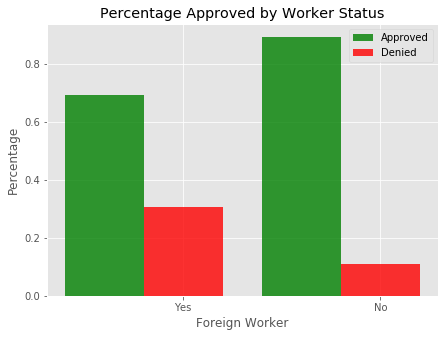

In [8]:
yes = data[data['foreign_worker'] == 1]
no = data[data['foreign_worker'] == 0]

yes_percentages = yes['class'].value_counts() / len(yes)
no_percentages = no['class'].value_counts() / len(no)

fw_approved = [yes_percentages[1], no_percentages[1]]
fw_denied = [yes_percentages[0], no_percentages[0]]

# data to plot
n_groups = 2
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, fw_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, fw_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Foreign Worker')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Worker Status')
plt.xticks(index + bar_width, ('Yes','No'))
plt.legend()

plt.show()
print('')


The difference between the approval rate of foreign workers is likely to be caused by the fact that only 3.7% of the loans are by foreign workers, whereas 96.3% are not. However, we will still reorder our catagories so that it has a better correlation with the class.

The value key for attribute foreign_worker goes from:

    0     Represents: Yes
    1     Represents: No

To:

    0     Represents: No                                            
    1     Represents: Yes  

In [9]:
relabeled = []

for item in data['foreign_worker']:  
    if item == 0:
        relabeled.append(1)
    elif item == 1:
        relabeled.append(0)
        
data['foreign_worker'] = relabeled

### Gender
Next, we will look at how the attribute gender affects the class.

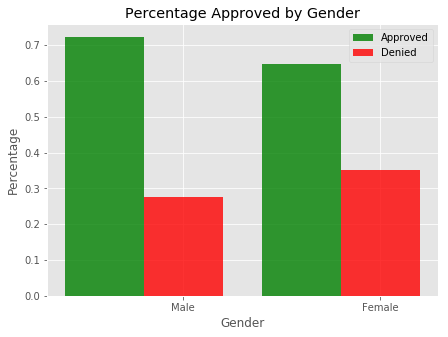

In [10]:
male = data[data['gender'] == 0]
female = data[data['gender'] == 1]

male_percentages = male['class'].value_counts() / len(male)
female_percentages = female['class'].value_counts() / len(female)

gender_approved = [male_percentages[1], female_percentages[1]]
gender_denied = [male_percentages[0], female_percentages[0]]

# data to plot
n_groups = 2
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, gender_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, gender_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Gender')
plt.xticks(index + bar_width, ('Male','Female'))
plt.legend()

plt.show()
print('')

Gender doesn't appear to have a huge influence on the class of the loan, however, males have a slightly higher percentage of approved loans than females. We will reorder our catagories to reflect this.

The value key for attribute gender goes from:

    0     Represents: Male
    1     Represents: Female

To:

    0     Represents: Female
    1     Represents: Male

In [11]:
relabeled = []

for item in data['gender']:  
    if item == 0:
        relabeled.append(1)
    elif item == 1:
        relabeled.append(0)
        
data['gender'] = relabeled

### Housing
First, we will look at the housing variable and see how it affects the class.

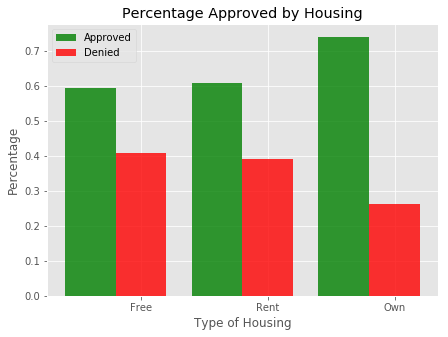

In [12]:
rent = data[data['housing'] == 0]
own = data[data['housing'] == 1]
free = data[data['housing'] == 2]

rent_percentages = rent['class'].value_counts() / len(rent)
own_percentages = own['class'].value_counts() / len(own)
free_percentages = free['class'].value_counts() / len(free)

housing_approved = [free_percentages[1],rent_percentages[1], own_percentages[1]]
housing_denied = [free_percentages[0], rent_percentages[0], own_percentages[0]]

# data to plot
n_groups = 3
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, housing_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, housing_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Type of Housing')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Housing')
plt.xticks(index + bar_width, ('Free','Rent','Own'))
plt.legend()

plt.show()

print('')


From the bar chart, we can tell that a transaction is more likely to be approved if the person currently own's their home versus renting or living for free. We choose to reorder our variables so that we have a better corrolation with class.

The value key for attribute housing goes from:

    0     Represents: Rent                                         
    1     Represents: Own                                           
    2     Represents: For Free 

to:

    0     Represents: For Free
    1     Represents: Rent
    2     Represents: Own
    

In [13]:
relabeled = []

for item in data['housing']:  
    if item == 0:
        relabeled.append(1)
    elif item == 1:
        relabeled.append(2)
    elif item == 2:
        relabeled.append(3)
        
data['housing'] = relabeled


### Job
Next, we will look at the job variable and see how it impacts the class.

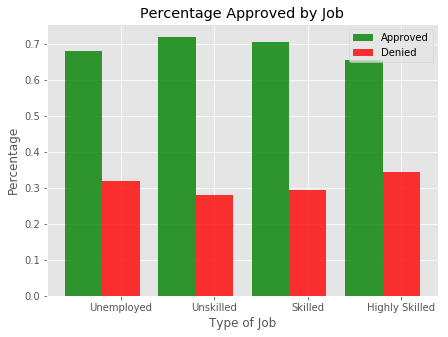

In [14]:
unemployed = data[data['job'] == 0]
unskilled = data[data['job'] == 1]
skilled = data[data['job'] == 2]
highly_skilled = data[data['job'] == 3]

unemployed_percentages = unemployed['class'].value_counts() / len(unemployed)
unskilled_percentages = unskilled['class'].value_counts() / len(unskilled)
skilled_percentages = skilled['class'].value_counts() / len(skilled)
highly_skilled_percentages = highly_skilled['class'].value_counts() / len(highly_skilled)

job_approved = [unemployed_percentages[1], unskilled_percentages[1], skilled_percentages[1], highly_skilled_percentages[1]]
job_denied = [unemployed_percentages[0], unskilled_percentages[0], skilled_percentages[0], highly_skilled_percentages[0]]

# data to plot
n_groups = 4
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, job_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, job_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Type of Job')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Job')
plt.xticks(index + bar_width, ('Unemployed','Unskilled', 'Skilled','Highly Skilled'))
plt.legend()

plt.show()

print('')

From the data, it appears that the most likely job to be approved for a loan is 'Unskilled' and the least likely is 'Highly Skilled' (Note: the 'Highly Skilled' being the lowest does seem odd, but it does include business owners as well which might be skewing the data). We reordered the data so that it has a more positive corrolation with class.

The value key for attribute job goes from:

    0     Represents: Unemployed       
    1     Represents: Unskilled             
    2     Represents: Skilled                                    
    3     Represents: Highly Skilled

To:

    0     Represents: Highly Skilled
    1     Represents: Unemployed
    2     Represents: Skilled
    3     Represents: Unskilled
    

In [15]:
relabeled = []

for item in data['job']:  
    if item == 0:
        relabeled.append(1)
    elif item == 1:
        relabeled.append(3)
    elif item == 2:
        relabeled.append(2)
    elif item == 3:
        relabeled.append(0)
        
data['job'] = relabeled

### Purpose
Next, we will look at how purpose affects class.

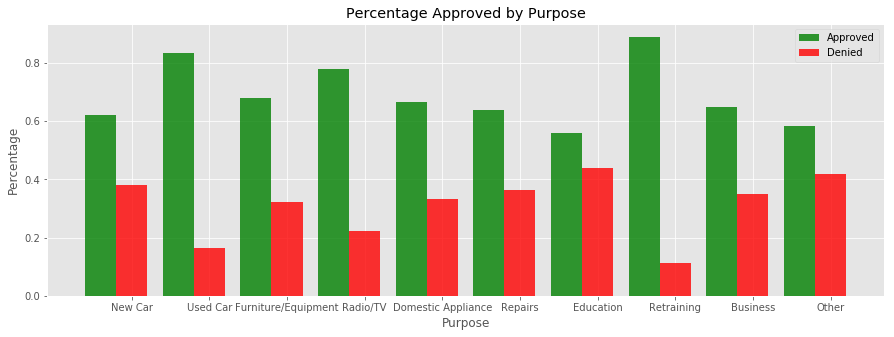

In [16]:
ncar = data[data['purpose'] == 0]
ucar = data[data['purpose'] == 1]
furn = data[data['purpose'] == 2]
rdtv = data[data['purpose'] == 3]
domapp = data[data['purpose'] == 4]
repair = data[data['purpose'] == 5]
education= data[data['purpose'] == 6]
retrain = data[data['purpose'] == 8]
business = data[data['purpose'] == 9]
other = data[data['purpose'] == 10]

ncar_percentages = ncar['class'].value_counts() / len(ncar)
ucar_percentages = ucar['class'].value_counts() / len(ucar)
furn_percentages = furn['class'].value_counts() / len(furn)
rdtv_percentages = rdtv['class'].value_counts() / len(rdtv)
domapp_percentages = domapp['class'].value_counts() / len(domapp)
repair_percentages = repair['class'].value_counts() / len(repair)
education_percentages = education['class'].value_counts() / len(education)
retrain_percentages = retrain['class'].value_counts() / len(retrain)
business_percentages = business['class'].value_counts() / len(business)
other_percentages = other['class'].value_counts() / len(other)

purpose_approved = [ncar_percentages[1], ucar_percentages[1], furn_percentages[1], 
                    rdtv_percentages[1], domapp_percentages[1], repair_percentages[1],
                    education_percentages[1], retrain_percentages[1], business_percentages[1],
                    other_percentages[1]]
purpose_denied = [ncar_percentages[0], ucar_percentages[0], furn_percentages[0], 
                  rdtv_percentages[0], domapp_percentages[0], repair_percentages[0],
                  education_percentages[0], retrain_percentages[0], business_percentages[0],
                  other_percentages[0]]

# data to plot
n_groups = 10
 
# create plot
fig, ax = plt.subplots(figsize=(15,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, purpose_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, purpose_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Purpose')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Purpose')
plt.xticks(index + bar_width, ( 'New Car', 'Used Car','Furniture/Equipment', 'Radio/TV',
                                'Domestic Appliance',  'Repairs', 'Education', 'Retraining',
                               'Business', 'Other'))
plt.legend()

plt.show()
print('')


One important thing to note is that the Vacation variable had no loans belonging to it, so we did not include it in the above charts.

We can see that the purpose variable seems to have a high variability between each of its catagories, with the highest number of denied going to Education and the lowest going to Retraining. So we reordered the catagories so that it would have a more positive correlation with class.

The value key for attribute purpose goes from:

    0     Represents: New Car
    1     Represents: Used Car
    2     Represents: Furniture/Equipment
    3     Represents: Radio/TV
    4     Represents: Domestic Appliance
    5     Represents: Repairs
    6     Represents: Education
    7     Represents: Vacation
    8     Represents: Retraining
    9     Represents: Business
    10    Represents: Other



To:

    0     Represents: Vacation                                  
    1     Represents: Education                                
    2     Represents: Other            
    3     Represents: New Car                                 
    4     Represents: Repairs            
    5     Represents: Business                                     
    6     Represents: Domestic Appliance                               
    7     Represents: Furniture/Equipment                                  
    8     Represents: Radio/TV                               
    9     Represents: Used Car                                 
    10    Represents: Retraining 

In [17]:
relabeled = []

for item in data['purpose']:  
    if item == 0:
        relabeled.append(3)
    elif item == 1:
        relabeled.append(9)
    elif item == 2: 
        relabeled.append(7)
    elif item == 3:
        relabeled.append(8)
    elif item == 4:
        relabeled.append(6)
    elif item == 5:
        relabeled.append(4)
    elif item == 6:
        relabeled.append(1)
    elif item == 7:
        relabeled.append(0)
    elif item == 8:
        relabeled.append(10)
    elif item == 9:
        relabeled.append(5)
    elif item == 10:
        relabeled.append(2)
        
data['purpose'] = relabeled

### Extra Visualization

Evaluating the correlation between our variables.

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

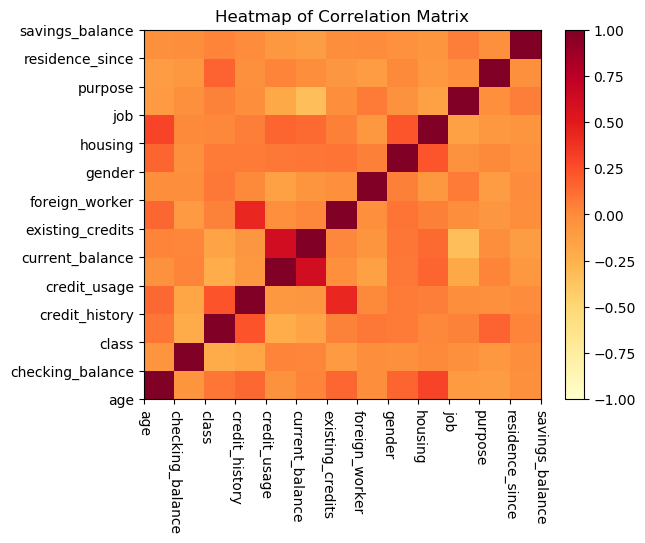

In [18]:
# Computing the correlation matrix
correlation = data.corr()

# Calculate and visualize correlations as matrix
plt.style.use('default')
heatmap = plt.pcolor(correlation, cmap=plt.cm.YlOrRd, vmin = -1, vmax = 1)

# Plot the legend on the side
plt.colorbar(heatmap)
plt.xticks(np.arange(14), ['age', 'checking_balance','class', 'credit_history',
           'credit_usage', 'current_balance', 'existing_credits',
           'foreign_worker', 'gender', 'housing', 'job',  
            'purpose', 'residence_since', 'savings_balance'], 
        rotation = -90)
plt.yticks(np.arange(14), ['age', 'checking_balance','class', 'credit_history',
           'credit_usage', 'current_balance', 'existing_credits',
           'foreign_worker', 'gender', 'housing', 'job',  
            'purpose', 'residence_since', 'savings_balance'])

plt.title("Heatmap of Correlation Matrix")

In this scatter plot we compared the highest correlated values to see if we were able to visualize any clear predictors in a good vs bad loan. 

Those variables being current balance and credit usage.

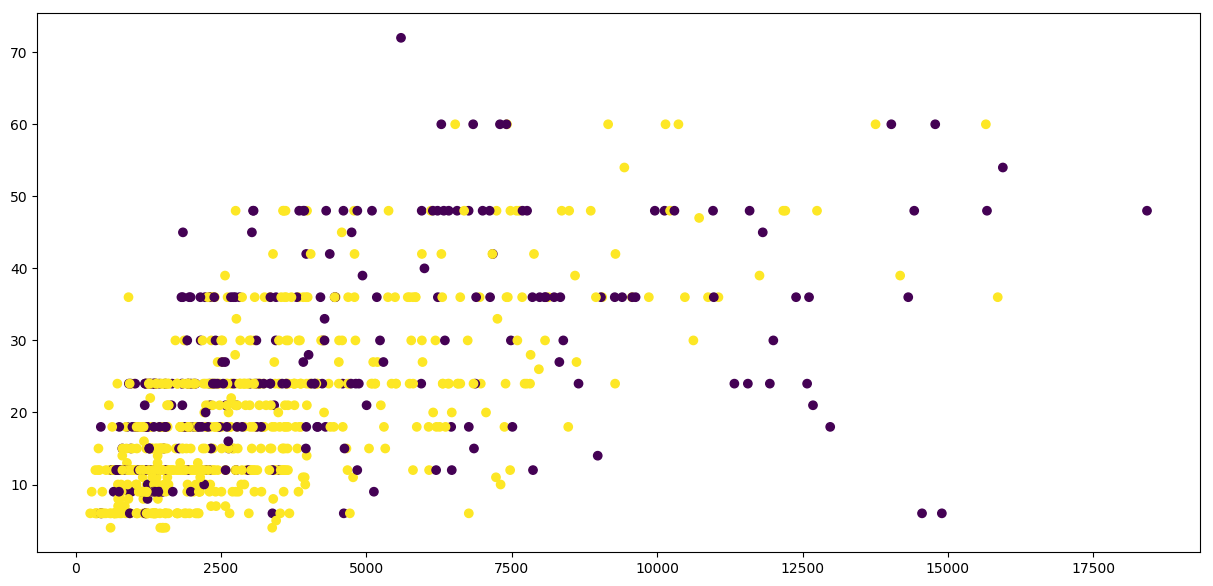

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(x = data['current_balance'], y = data['credit_usage'],c = data['class'])
plt.show()

The variables as seen above do not individually give a clear picture to class definition.

## Creating the Machine Learning Algorithm

### Scaling the data.

Before plugging our variables into our ML models, we satndardize the floats around 0. 

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()
# scaling age
scaled_age = scaler.fit_transform(data[['age']])
flat_list1 = [item for sublist in scaled_age.tolist() for item in sublist]
scaled_age = pd.Series(flat_list1)

In [21]:
# scaled credit_usage.
scaled_cu = scaler2.fit_transform(data[['credit_usage']])
flat_list2 = [item for sublist in scaled_cu.tolist() for item in sublist]
scaled_cu = pd.Series(flat_list2)

In [22]:
# scaled current_balance.
scaled_cb = scaler3.fit_transform(data[['current_balance']])
flat_list3 = [item for sublist in scaled_cb.tolist() for item in sublist]
scaled_cb = pd.Series(flat_list3)

In [23]:
# scaled existig_credits
scaled_ec = scaler4.fit_transform(data[['existing_credits']])
flat_list4 = [item for sublist in scaled_ec.tolist() for item in sublist]
scaled_ec = pd.Series(flat_list4)

In [24]:
# concatenating newly created columns with original data
data1 = pd.concat([data, scaled_ec.rename('scaled_existing_credits'), scaled_cb.rename('scaled_current_balance'), scaled_cu.rename('scaled_credit_usage') ,scaled_age.rename('scaled_age')], axis=1)
data1.head()

,age,checking_balance,class,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
0,67.0,1,1,4,6.0,1169.0,2.0,0,1,2,2,8,0,1.027079,-0.745131,-1.236478,2.766456
1,22.0,2,0,2,48.0,5951.0,1.0,0,0,2,2,8,1,-0.704926,0.949817,2.248194,-1.191404
2,49.0,0,1,4,12.0,2096.0,1.0,0,1,2,3,1,1,-0.704926,-0.416562,-0.738668,1.183312
3,45.0,1,1,2,42.0,7882.0,1.0,0,1,3,2,7,1,-0.704926,1.634247,1.750384,0.831502
4,53.0,1,0,3,24.0,4870.0,2.0,0,1,3,2,3,1,1.027079,0.566664,0.256953,1.535122


In [25]:
# Drop Old Entries for scaled columns.
data1.drop(['age', 'credit_usage', 'current_balance', 'existing_credits'], axis=1, inplace=True)
data1.head()

,checking_balance,class,credit_history,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
0,1,1,4,0,1,2,2,8,0,1.027079,-0.745131,-1.236478,2.766456
1,2,0,2,0,0,2,2,8,1,-0.704926,0.949817,2.248194,-1.191404
2,0,1,4,0,1,2,3,1,1,-0.704926,-0.416562,-0.738668,1.183312
3,1,1,2,0,1,3,2,7,1,-0.704926,1.634247,1.750384,0.831502
4,1,0,3,0,1,3,2,3,1,1.027079,0.566664,0.256953,1.535122


Once all our floats were standardized we concantenated the new values into the old data set and removed the old column values. 

### Splitting Data into Train and Test sets.

manual train test split using numpy's random.rand

In [26]:
mask = np.random.rand(len(data1)) > 0.2
train = data1[mask]
test = data1[~mask]
print('Train Shape: {}\nTest Shape: {}'.format(train.shape, test.shape))

Train Shape: (828, 13)
Test Shape: (172, 13)


In [27]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### Balancing the data set.

Creating a training data set that will allow our algorithms to pick up the specific characteristics that make a loan application more or less likely to be approved or denied. Using the original data set we aquired would not prove to be a very good idea for our analysis. This being due to the fact that 70% of our applications processed were approved, and an algorithm that always predicts that an application is approved would achieve an accuracy higher than 70%. Nevertheless, that is the opposite of what we want. We do not want a 70% accuracy that is achieved by never labeling a loan application as approved, we want to detect denied applications due to high risk of default.


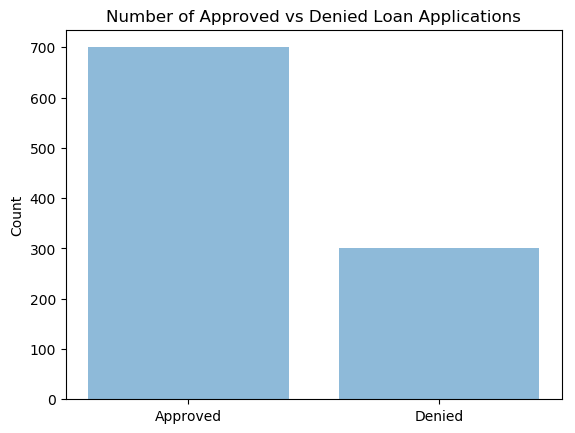

In [28]:
objects = ('Approved', 'Denied')
y_pos = np.arange(len(objects))
performance = [700,300]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Approved vs Denied Loan Applications')
 
plt.show()

In [29]:
no_of_frauds = train['class'].value_counts()[0]
print('There are {} fraudulent transactions in the train data.'.format(no_of_frauds))

There are 249 fraudulent transactions in the train data.


From the graph above we can see that 300 of our applications were classified as bad/potentially fraudulent. So we will randomly select 300 bad and good transactions.

In [30]:
fraud = train[train['class'] == 0]
non_fraud = train[train['class'] == 1]

In [31]:
selected = non_fraud.sample(no_of_frauds)
selected.head()

,checking_balance,class,credit_history,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
40,0,1,2,0,1,2,2,8,1,-0.704926,-0.712168,-0.738668,-0.927547
556,0,1,2,0,1,2,0,3,1,-0.704926,2.514684,3.243815,0.567645
775,0,1,4,0,1,2,0,9,0,1.027079,1.265626,0.256953,0.919455
60,2,1,3,0,1,2,2,8,1,-0.704926,0.531574,-0.821636,1.359217
250,0,1,2,0,1,2,2,7,4,-0.704926,-0.612570,-1.236478,-0.223927


In [32]:
# concatenating both into a subsample data set with equal class distribution
selected.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [33]:
subsample = pd.concat([selected, fraud])
len(subsample)

498

In [34]:
# Re-shuffling the data set since when we concatenate the data it orders the first 'n' as 0 and next 'n' as 1.
subsample = subsample.sample(frac=1).reset_index(drop=True)
subsample.head(10)

,checking_balance,class,credit_history,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
0,0,0,2,0,0,2,0,7,1,1.027079,2.730186,1.252574,-0.839594
1,3,1,2,1,1,2,1,3,4,-0.704926,-0.908175,-1.236478,-0.751642
2,3,0,2,0,1,2,3,7,1,-0.704926,-0.144350,-0.240857,-0.135974
3,2,1,4,0,1,2,0,9,1,1.027079,-0.500211,-0.738668,-0.135974
4,1,0,0,0,1,1,2,7,1,1.027079,0.297287,0.256953,-1.103451
5,0,1,3,0,0,2,2,7,4,1.027079,-0.819210,-0.489762,-0.487784
6,2,0,0,0,1,2,3,5,1,2.759084,0.343719,0.256953,0.039930
7,1,1,2,0,1,2,2,7,0,-0.704926,-0.375447,-0.074920,0.303788
8,0,1,2,0,1,2,2,8,0,-0.704926,-0.039435,0.008048,0.479693
9,0,1,2,0,1,2,2,8,1,-0.704926,-0.349927,0.256953,-0.663689


Text(0.5, 0, 'Class (0:Approved, 1:Denied)')

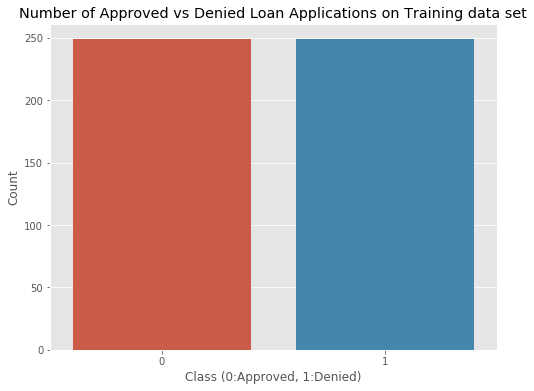

In [57]:
new_counts = subsample['class'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=new_counts.index, y=new_counts)
plt.title('Number of Approved vs Denied Loan Applications on Training data set')
plt.ylabel('Count')
plt.xlabel('Class (0:Approved, 1:Denied)')

In [36]:
#taking a look at correlation concerning only class once more.
corr = subsample.corr()
corr = corr[['class']]
corr

,class
checking_balance,-0.251420
class,1.000000
credit_history,0.287419
foreign_worker,0.068314
gender,0.063992
housing,-0.035454
job,0.018543
purpose,0.180458
savings_balance,0.008736
scaled_existing_credits,0.086367


### Dimensionality Reduction.

Attempting to reduce our data to a smaller dimension in order to Remove redundancies and simplifies the dataset making it easier to understand as well as reducing dimensionality can help avoid overfitting in supervised learning tasks using principal component analysis.

In [37]:
from sklearn.manifold import TSNE

X = subsample.drop('class', axis=1)
y = subsample['class']

In [38]:
# PCA analysis. find PCA and transform to new coordinates
pca_model = PCA()
D_PCA = pca_model.fit_transform(X)

# create a new pandas dataframe 
df_plot = pd.DataFrame(D_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'])
df_plot.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-1.270953,2.591727,1.351481,-1.134880,-0.738200,-0.758711,-0.593773,1.803595,0.264933,0.000110,0.703637,0.028487
1,2.750268,-0.852482,-1.862750,-0.080881,2.952166,0.768859,-1.741390,0.838098,0.047771,-0.341514,-0.215438,0.897730
2,-1.139153,-0.133475,-1.218548,0.307682,0.863097,1.389460,0.981320,-0.680669,0.689179,-0.244442,-0.181862,-0.025347
3,-3.016849,-0.952425,1.568697,-0.237943,0.249269,2.062355,-1.044165,0.925515,-0.575128,-0.214243,-0.175658,-0.021877
4,-1.300806,0.519731,-1.274422,-0.390228,-0.159949,-0.606690,1.382754,2.065184,0.127578,0.152273,-0.660609,0.014953


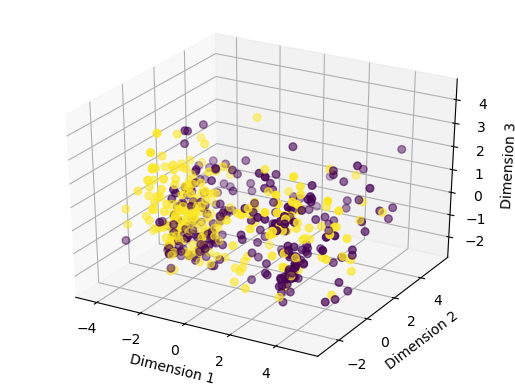

In [39]:
# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(D_PCA[:, 0], D_PCA[:, 1],zs= D_PCA[:, 2], c=y, s=30)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

[0.423837   0.12780064 0.10751575 0.07037984 0.06081175 0.05422309
 0.04914266 0.04350462 0.0291111  0.01894067 0.01329415 0.00143874]


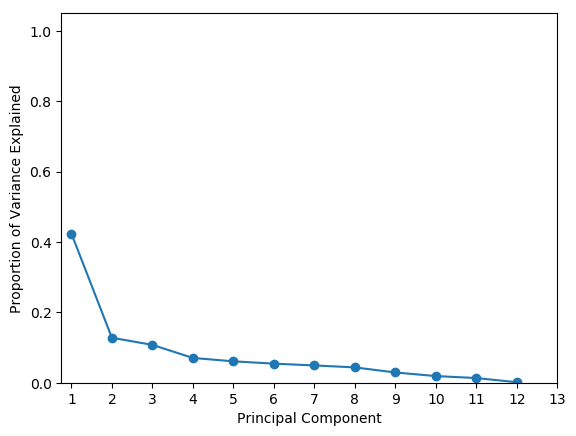

In [40]:
# Variance ratio of the principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.show()

Not ideal results, this shows us that our decision between approval and denial at an accuracy of approxiamtley 90% we would need to use the first 8 principal components.

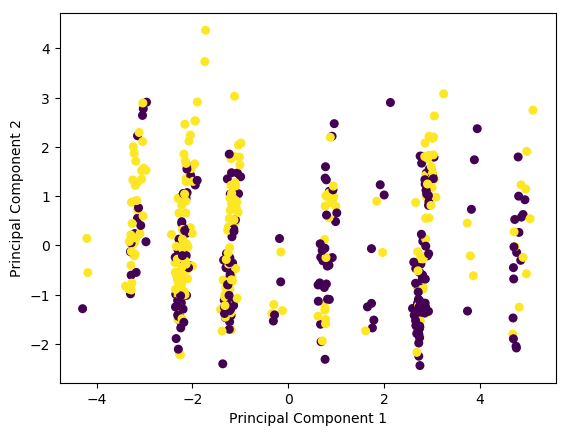

In [41]:
plt.scatter(D_PCA[:, 0], D_PCA[:, 2], c=y, s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [42]:
# t-SNE
X_reduced_tsne = TSNE(n_components=3, random_state=42).fit_transform(X.values)

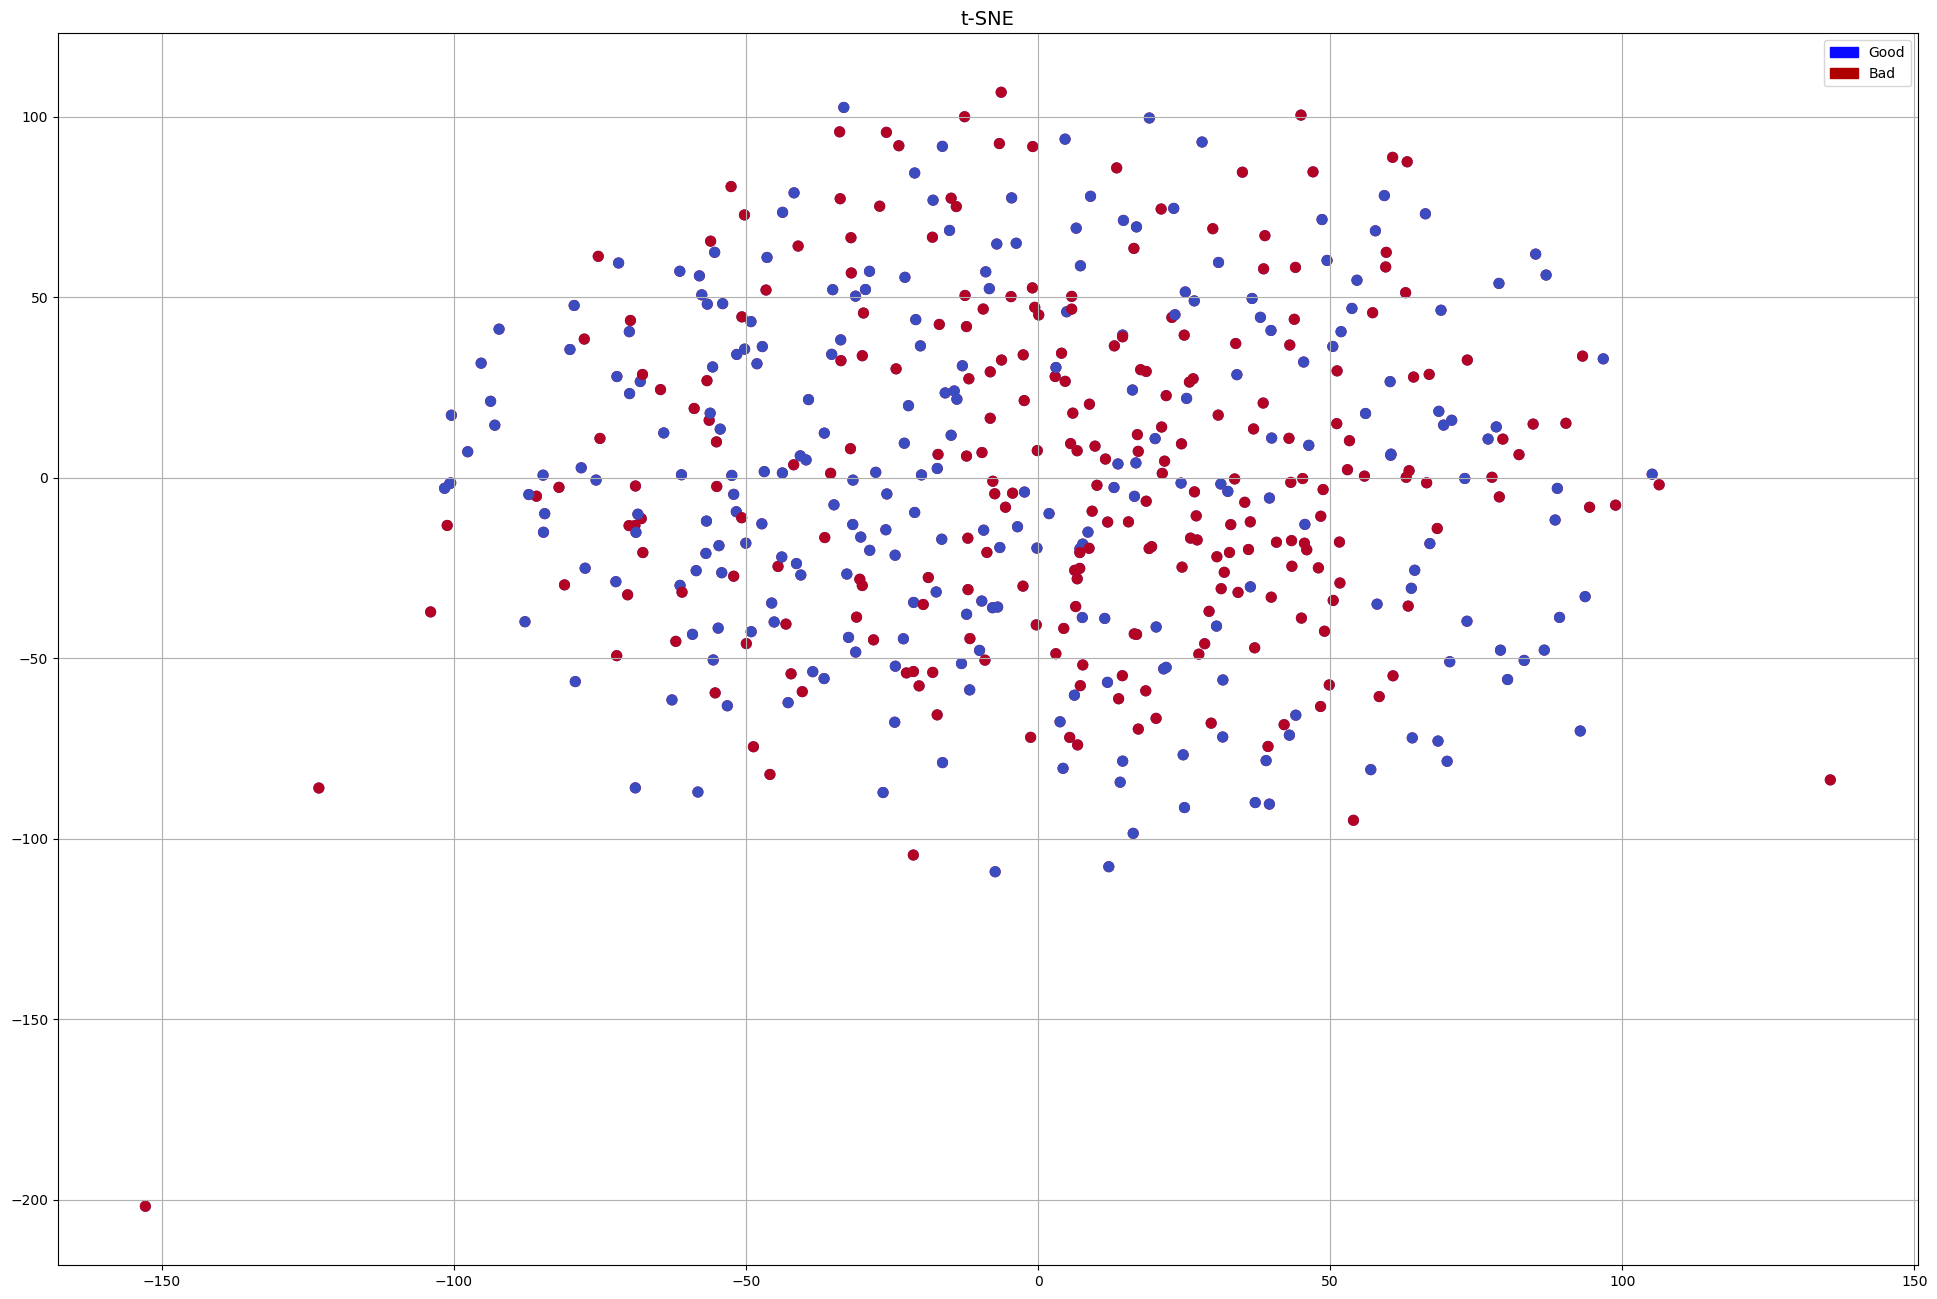

In [43]:
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='Good')
red_patch = mpatches.Patch(color='#AF0000', label='Bad')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Bad', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Good', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

Graph showing that when we project our data into a lower dimension showing that our class decision is not easlily seperable and many facotrs contribute to an approval/denial.

### Quick Machine Learning computations.

Setting up our Train vs Test sets and using a loop function on different ML techniques to determine their ROC-AUC scores. 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

In [45]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [46]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (149, 12) (349, 12) 

Y_shapes:
 Y_train: Y_validation:
 (149,) (349,)


In [47]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.711804 (0.094161)
LDA: 0.700961 (0.114490)
KNN: 0.629005 (0.118691)
CART: 0.623712 (0.105357)
SVM: 0.671430 (0.132510)
RF: 0.710129 (0.123615)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


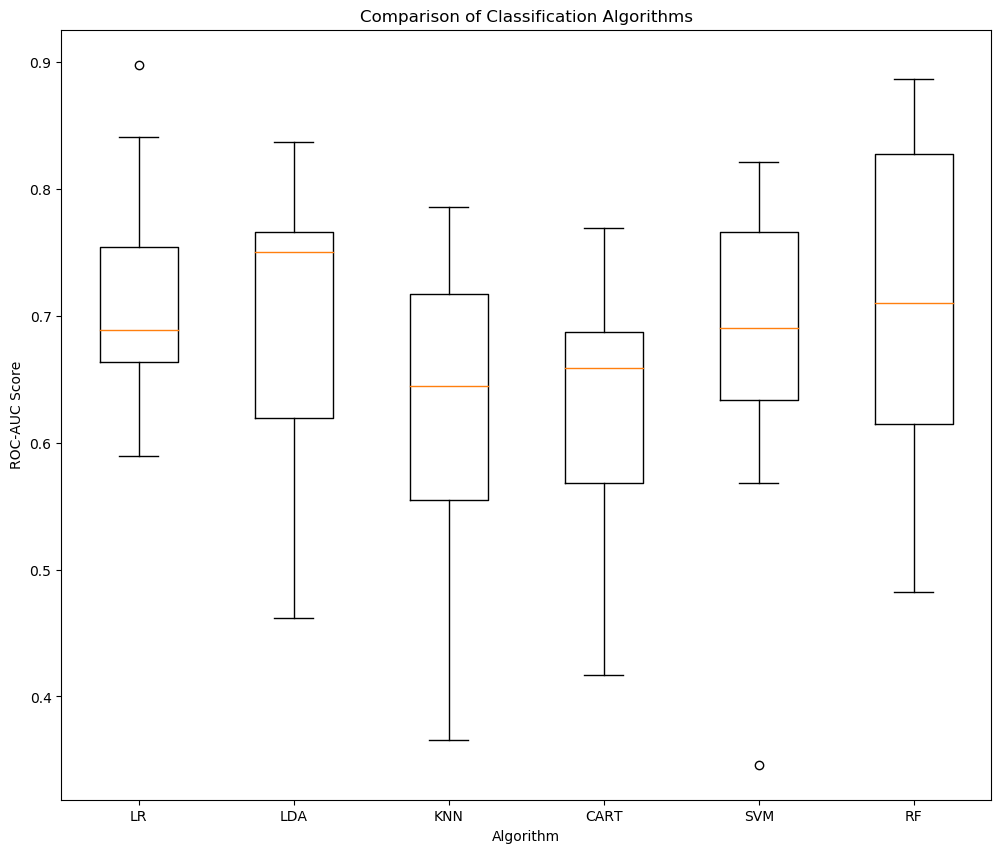

In [48]:
fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

### Percepitron Algorithm

This was reccommended to be our baseline algorithm, but after testing multiple ways our data was very hard to classify with this linear model, but we try it anyways.

Since the Perceptron algorithm uses float variable types we will just use certain columns from our dataset.

In [49]:
# Build a classifier using the training dataset.
perceptron = Perceptron(tol = 1e-3, fit_intercept = True, max_iter = 100)
perceptron.fit(X_train, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = perceptron.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.6160458452722063
Confusion Matrix:
[[ 80  96]
 [ 38 135]]


### Multiple Layer Percepitron Algorithm

Attempted to see if we could get a better prediction using a MLP.

In [54]:
y = data1['class']
X1 = data1[['savings_balance','scaled_existing_credits','scaled_current_balance','scaled_credit_usage','scaled_age']]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

# manual train test split using numpy's random.rand
mask = np.random.rand(len(data1)) < 0.9
train = data1[mask]
test = data1[~mask]
print('Train Shape: {}\nTest Shape: {}'.format(train.shape, test.shape))


mlp = MLPClassifier(hidden_layer_sizes=(4,3),max_iter=10000)

mlp.fit(X_train,y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

Train Shape: (895, 13)
Test Shape: (105, 13)
[[  8  51]
 [  5 136]]
              precision    recall  f1-score   support

           0       0.62      0.14      0.22        59
           1       0.73      0.96      0.83       141

   micro avg       0.72      0.72      0.72       200
   macro avg       0.67      0.55      0.53       200
weighted avg       0.69      0.72      0.65       200



In conclusion we discoverd that the multi-layer percepitron did give a much better accuracy score then our single-layer percepitron. 

MLP: ~81% 
Percepitron: ~60%

### SVM Model

In [51]:
# Build a classifier using the training dataset.
SVM_model = svm.SVC(kernel='rbf', C = 25, gamma = 'scale')
SVM_model.fit(X_train, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = SVM_model.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.7014285714285714
Confusion Matrix:
[[ 63 145]
 [ 64 428]]


### Decision Tree

In [52]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 3)

# fit the tree with the traing data
decisionTree = decisionTree.fit(X_train, y_train)

# predict with the training data
y_pred_train = decisionTree.predict(X_train)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  0.77
Accuracy on test data =  0.7


When training and testing using all of our data we get a 100% accuracy on the training data set which is expected since this would overfit the data. But, we still recieve a faily low accuracy on our test set.


### Random Forest

In [53]:
forest =  RandomForestClassifier(max_depth = 4, bootstrap=True, n_estimators=100, random_state=0)

trained_forest = forest.fit(X_train, y_train)

y_pred_train = trained_forest.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = trained_forest.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data=  0.7866666666666666
Accuracy on test data=  0.71
